# Deep Learning - Proyecto Final

## Predicción de Tiempo de recorrido en actividades de Trail Running

## Procesamiento de Datos

La lógica de procesamiento de datos se encuentra implementada en la clase `DataProcessor` dentro del archivo [data_processor.py](utils/data_processor.py). El dispositivo de registro es un reloj Polar Vantage V. Los datos de Polar se encuentran estructurados en formato JSON por lo que es importante poder pasarlos a un formato tabular antes de su procesamiento en el modelo.

El procesamiento de estos datos consiste en extraer y transformar información de archivos JSON que contienen registros de actividades de trail running. El script filtra las actividades por tipo de deporte (TRAIL_RUNNING) y duración (entre 4 y 6 horas). Para cada actividad válida, se extraen muestras de sensores como frecuencia cardíaca, altitud, distancia, temperatura, cadencia y velocidad.

Las muestras se organizan en un DataFrame, donde se realizan varias tareas de ingeniería de características:

Distancia: Se calcula la diferencia entre muestras consecutivas para obtener el avance por intervalo.
Altitud: Se suavizan los datos y se calculan diferencias de elevación, ganancia y pérdida acumulada.
Duración: Se calcula el tiempo acumulado entre muestras.

El procesamiento se realiza de forma eficiente, permitiendo el uso de múltiples hilos para acelerar la conversión de archivos. Los datos procesados se guardan en archivos CSV estructurados, listos para su análisis y modelado.

### Remuestreo

El objetivo del proyecto es realizar una predicción del tiempo por lo que se hizo un remuestreo de los datos para que las muestras estén a intervalos constantes de distancia. La lógica del remuestreo se encuentra en la clase `DataResampler` en el archivo [data_resampling.py](./utils/data_resampling.py).

Se tomaron los archivos de datos de actividades del paso anterior y se los transformó para que las muestras estén espaciadas a intervalos constantes de distancia (cada 2 metros). El proceso incluyó:

- Carga de los datos y conversión de la columna de tiempo a formato datetime. 
- Relleno de valores faltantes en las variables de frecuencia cardíaca, cadencia, velocidad y distancia usando el promedio o el valor anterior.
- Eliminación de duplicados y creación de un nuevo índice de distancia con pasos de 2 metros.
- Interpolación de los valores para obtener datos continuos en esos intervalos.
- Almacenamiento de los archivos remuestreados en formato CSV en una carpeta de salida.


### Análisis Exploratorio de Datos

In [1]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 106


In [2]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    # df['temperature'] = df['temperature'].fillna(method='ffill')
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164615 entries, 0 to 1164614
Data columns (total 15 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   distance            1164615 non-null  float64
 1   timestamp           1164615 non-null  object 
 2   heartRate           1164615 non-null  float64
 3   duration            1164615 non-null  float64
 4   altitude            1164615 non-null  float64
 5   distance_diff       1164615 non-null  float64
 6   temperature         1164615 non-null  float64
 7   cadence             1164615 non-null  float64
 8   speed               1164615 non-null  float64
 9   elevation_diff      1164615 non-null  float64
 10  elevation_gain      1164615 non-null  float64
 11  elevation_loss      1164615 non-null  float64
 12  session_id          1164615 non-null  object 
 13  time_idx            1164615 non-null  int64  
 14  session_id_encoded  1164615 non-null  int64  
dtypes: float64(11),

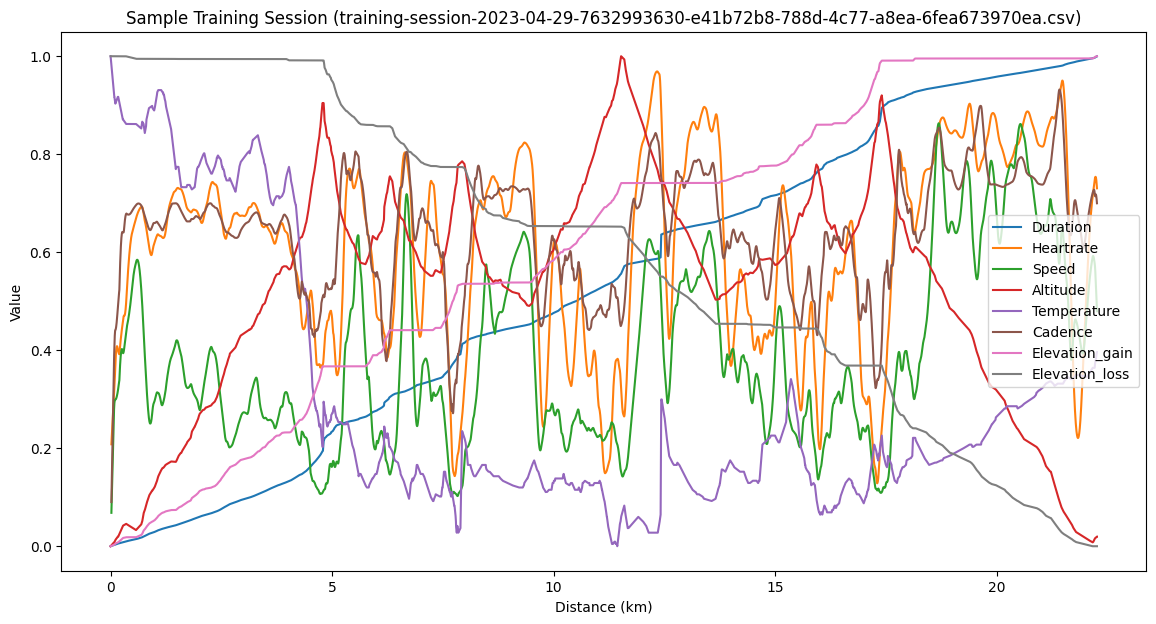

In [3]:
# Plot heart rate over distance
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

#Normalize sample data (scale between 0 and 1 for better visualization)
normalized_cols = {}
for col in ['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss']:
    normalized_cols[col] = (sample_data[col] - sample_data[col].min()) / (sample_data[col].max() - sample_data[col].min())

# Smooth speed data using rolling average for visualization
normalized_cols['speed'] = normalized_cols['speed'].rolling(window=100, min_periods=10).mean()
normalized_cols['heartRate'] = normalized_cols['heartRate'].rolling(window=100, min_periods=10).mean()
normalized_cols['cadence'] = normalized_cols['cadence'].rolling(window=100, min_periods=10).mean()

plt.figure(figsize=(14, 7))
distance_km = sample_data['distance'] / 1000
for col in normalized_cols:
    plt.plot(distance_km, normalized_cols[col], label=col.capitalize())

plt.xlabel('Distance (km)')
plt.ylabel('Value')
plt.title(f'Sample Training Session ({sample_file})')
plt.legend()
plt.show()


A simple vista se puede observar ciertas correlaciones entre algunas de las variables. El modelo se encargará de hacer la selección de las variables más apropiadas para el caso

### DataModule

Se implementó la clase `TFTDataModule` usando `LightningDataModule` de PyTorch Lightning y la clase `TimeSeriesDataSet` de la libreria `pytorch forecasting` específicamente diseñada para trabajar con modelos de series de tiempo.

#### Carga de Datos

El módulo carga los datos automaticamente. La función prepare_data lee todos los datos y realiza algunas operaciones necesarias para integrarla con los módulos de la libreria de `pytorch-forecasting`. Por ejemplo, se agregan session identifiers como variable categorica y se convierte los valores de distance un `time_idx` que es un valor secuencial requerido por `TimeSeriesDataset`

#### División de Datos

Inicialmente se dividieron los datos temporalmente en proporciones 70:15:15 de entrenamiento, validación y test respectivamente, de acuerdo a las recomendaciones para series temporales para prevenir fuga de datos del pasado hacia los pasos de validación y test. Sin embargo el objetivo del proyecto es que el modelo tenga la capacidad de manejar predicciones sobre scenarios cold-start, es decir, el deportista no ha iniciado todavía el recorrido, por lo que se hizo la división basada en sesiones en lugar de divisiones temporales.

La implementación del DataModule incluye además:

- **Normalización por grupos**: Aplica `GroupNormalizer` por sesión para mejor generalización
- **Variables futuras**: Distingue entre variables conocidas y desconocidas en el futuro

**Parámetros configurables relevantes:**
- `max_encoder_length`: Longitud máxima del encoder (por defecto 200 pasos)
- `max_prediction_length`: Horizonte de predicción (por defecto 200 pasos)
- `batch_size`: Tamaño del lote para entrenamiento
- `target`: Variable objetivo a predecir ()

**Variables dependientes conocidas** (disponibles al momento de predicción):
- `altitude`: Altitud
- `elevation_diff`: Diferencia de elevación
- `elevation_gain`: Ganancia de elevación
- `elevation_loss`: Pérdida de elevación  
- `distance`: Distancia recorrida

**Variables dependientes desconocidas**:
- `heartRate`: Frecuencia cardíaca
- `temperature`: Temperatura
- `cadence`: Cadencia
- `speed`: Velocidad
- `duration`: Duración de la actividad

La hipótesis es que el modelo junto con la información apropiada permitirá al modelo TFT aprovechar la información conocida del terreno y la ruta para hacer predicciones muy precisas del tiempo de recorrido.

In [20]:
# Import the TFT DataModule
# import sys
# sys.path.append('./utils')
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=2,
    max_encoder_length=200,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()


Loading 106 training session files...
Loaded 106 sessions with 465939 total data points
Minimum required sequence length: 400
Valid sessions: 106/106
Loaded 106 sessions with 465939 total data points
Minimum required sequence length: 400
Valid sessions: 106/106
Session-based splits for cold-start evaluation:
Train sessions: 79, Val sessions: 15, Test sessions: 12
Train data points: 347748, Val: 72019, Test: 46172
Overlap between train-val: 0, train-test: 0
Session-based splits for cold-start evaluation:
Train sessions: 79, Val sessions: 15, Test sessions: 12
Train data points: 347748, Val: 72019, Test: 46172
Overlap between train-val: 0, train-test: 0
Training samples: 347511
Validation samples: 71974
Test samples: 12
Training samples: 347511
Validation samples: 71974
Test samples: 12


In [5]:
# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target length: {len(sample_batch[1][0])}")          # Number of target variables
print(f"Target variable shape: {sample_batch[1][0][2].shape}")    # [batch_size, prediction_length]


Batch structure:
Batch type: <class 'tuple'>
Input features shape: torch.Size([64, 200, 21])
Target length: 5
Target variable shape: torch.Size([64, 20])


## Modelo

### Temporal Fusion Transformer (TFT)

El **Temporal Fusion Transformer** (TFT) es un modelo de deep learning diseñado específicamente para predicción de series temporales que puede manejar tanto variables conocidas como desconocidas en el futuro.

Inicialmente se implementó una arquitectura custom dentro de la clase `TrailRunningTFT` enfocado a predecir el tiempo de recorrido en actividades de trail running como un módulo de *Pytorch Lightning*, instanciando el modelo `TemporalFusionTransformer` de la librería `pytorch-forecasting` dentro de la clase custom. Sin embargo, la clase `TemporalFusionTransformer` ya esta implementada como un módulo de *Pytorch Lightning* por lo que instanciar nuevamente resultó ser innecesario y se procedió a extender la clase para proveer de las customizaciones del caso que puediesen ser aplicadas al dominio especifico de las actividades del Trail Running.

**Características del modelo:**
- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales (secuenciales)
- **Variables conocidas futuras**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (disponibles en el momento de la predicción)
- **Variables desconocidas futuras**: `duration`, `heartRate`, `temperature`, `cadence`, `speed` (necesitan ser estimadas)
- **Variable objetivo**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`
- **Longitud de secuencia**: 40-200 pasos temporales de entrada
- **Horizonte de predicción**: 20 pasos hacia el futuro

## Entrenamiento

In [6]:
# # Entrenar el modelo
# import subprocess
# import sys

# # Ejecuta el script de entrenamiento usando subprocess
# script_path = "training.py"

# # Verificar que el script existe
# if not os.path.exists(script_path):
#     print(f"Error: No se encontró el archivo {script_path}")
#     exit(1)

# print("Iniciando entrenamiento del modelo TFT...")

# try:
#     # Ejecutar el script con subprocess
#     process = subprocess.Popen(
#         [sys.executable, script_path],
#         stdout=subprocess.PIPE,
#         stderr=subprocess.STDOUT,
#         universal_newlines=True,
#         bufsize=1
#     )
    
#     # Mostrar la salida en tiempo real
#     for line in process.stdout:
#         print(line.rstrip())
    
#     # Esperar a que termine el proceso
#     process.wait()
    
#     if process.returncode == 0:
#         print("Entrenamiento completado exitosamente!")
#     else:
#         print("\n" + "=" * 60)
#         print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
# except Exception as e:
#     print(f"Error al ejecutar el script: {str(e)}")


📊 Hyperparameters for version_11:
learning_rate            : 0.001
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 2
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)
target_variables         : duration, heartRate, temperature, cadence, speed


Plotting metrics for version_11...


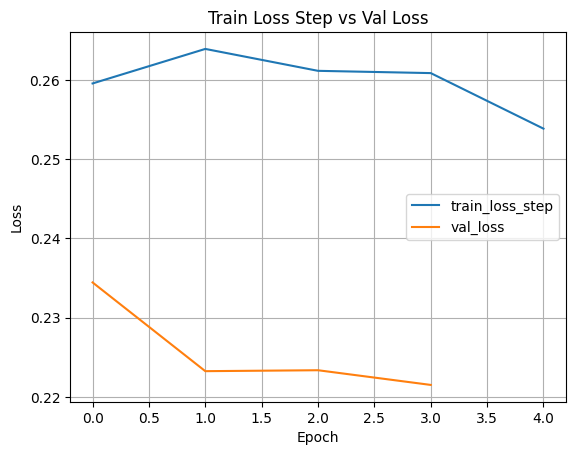

In [31]:
import os
import importlib
# reload utils.viz to ensure latest changes are used
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_metrics, extract_hparams

# Plot training and validation loss and extract hyperparameters
logs_dir = "./logs/tft_model/"
# for version in sorted(os.listdir(logs_dir)):
# for version in ['version_2', 'version_4', 'version_6', 'version_7', 'version_8', 'version_9']:
for version in ['version_11']:
    version_path = os.path.join(logs_dir, version)
    if not os.path.isdir(version_path):
        continue
    metrics_file = os.path.join(version_path, "metrics.csv")
    hparams_file = os.path.join(version_path, "hparams.yaml")
    
    # Extract and display hyperparameters (if they exist)
    if os.path.exists(hparams_file):
        print(f"\n📊 Hyperparameters for {version}:")
        print("=" * 50)
        
        try:
            params = extract_hparams(hparams_file)
            
            # Define the parameters we're interested in
            key_params = [
                'learning_rate',
                'dropout',
                'hidden_size',
                'hidden_continuous_size',
                'attention_head_size',
                'lstm_layers',
                'max_encoder_length',
                'max_prediction_length',
                'min_encoder_length',
                'weight_decay',
                'causal_attention',
                'optimizer',
                'reduce_on_plateau_patience',
                'reduce_on_plateau_min_lr',
                'reduce_on_plateau_reduction',
                'randomize_length',
                'predict_mode',
            ]
            
            # Display found parameters
            for param in key_params:
                if param in params:
                    print(f"{param:25}: {params[param]}")
            
            # Calculate and display total sequence length
            encoder_len = params.get('max_encoder_length', 'N/A')
            pred_len = params.get('max_prediction_length', 'N/A')
            if isinstance(encoder_len, int) and isinstance(pred_len, int):
                total_len = encoder_len + pred_len
                print(f"{'Total Sequence Length':25}: {total_len} ({encoder_len} encoder + {pred_len} prediction)")
            
            # Display target variables
            if 'target_variables' in params:
                print(f"{'target_variables':25}: {', '.join(params['target_variables'])}")
            
        except Exception as e:
            print(f"Error processing {hparams_file}: {str(e)}")
        
        print("\n" + "=" * 50 + "\n")

    if os.path.exists(metrics_file):
        print(f"Plotting metrics for {version}...")
        plot_metrics(
            metrics_file,
            plot_metrics=[["train_loss_step", "val_loss"]],
            # save_svg_path=os.path.join("./assets/", f"loss_plot_{version}.svg")
        )

## Análisis de Overfitting

Uno de los objetivos fue reducir el overfitting manteniendo la capacidad predictiva del modelo. Del análisis de las métricas de los entrenamientos iniciales se observó un claro overfitting. Se identificaron algunas posibles causas:

### Tamaño y diversidad del dataset en comparación a la complejidad del modelo

El problema principal en este caso es que se limitó el numero de muestras por dos motivos: filtrar sesiones de entrenamiento relativamente largas que puedan capturar información de la actividad física de resistencia y limitar el tamaño del dataset para tener un entrenamiento un poco más acelerado. Al mismo tiempo se quería procesar longitudes de secuencia largas para capturar dependencias en ventanas mas grandes, sin embargo, esto al mismo tiempo causa que el modelo tenga más parámetros entrenables y por lo tanto se vuelva mas complejo.

Otro problema, es que muchas de las sesiones tienen condiciones diferentes de las cuales el modelo no tiene conocimiento, algunas de las cuales son:
- No hay distincion entre sensiones de entrenamiento y sesiones de competencia. El RPE (Rate of Perceived Effort) puede ser muy diferente en una competencia que un entrenamiento, usualmente los entrenamientos largos sobre todo se llevan a cabo en su mayoría en un RPE entre 3 y 4 con pequeños intervalos de RPE entre 5 a 8. Mientras que una competencia tiene su mayoria un RPE entre 5 a 8, con periodos de recuperación con RPE entre 2 y 4. Otro problema es que no se esta identificando la ingesta de calorías, hidratación o ayudas ergogénicas que podrían tener un impacto significativo en el desempeño del deportista.

Una solución futura será incluir un mayor numero de muestras en el modelo e incluir etiquetas adicionales a los datos como RPE.

### Balanceo de datos

Un problema identificado fue que la configuración inicial tenia `predict=True` en `TimeSeriesDataSet.from_dataset()` para el set de validación. Esto creaba solo **1 muestra por sesión** para validación. Inicialmente esto parecia normal puesto que la división de datos se hizo basada en las sesiones, pero al comparar con las muestras identificadas por el dataloader para el entrenamiento había un desbalance significativo. Luego de una revisión de la documentación de la libreria se pudo entender mejor el proposito del parametro (https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.from_dataset). Se cambió a `predict=False` en los parametros de la creación del dataset para obtener múltiples muestras por sesión.

### Secuencias Muy Largas

Inicialmente se configuró al modelo para tener un encoder de 250 pasos + predicción de 50 pasos = 300 pasos totales, con el fin de tener una longitud que pudiese capturar las dependencias temporales de alta resistencia. Esto al mismo tiempo volvio al modelo muy complejo para el tamaño del dataset. Se probarón algunas combinaciones sin un impacto significativo. Al final, se procedió a reducir el encoder a una longitud de 200 + predicción de 40 = 240 pasos totales

### Falta de Regularización
Inicialmente no se tendía una randomización de la longitud de las secuencias y se tenia un dropout bajo (0.1) Tampoco se habia configurado `weight_decay` para regularización. Se procedió a activar `randomize_length=True`, aumentar dropout a 0.3 y agregar `weight_decay`.

### Predicción Multi-objetivo Compleja
En este caso se tienen 5 variables objetivo simultáneas con 21 características de entrada. Weighted Loss como solucion.



## Evaluación

In [45]:
import torch
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from training import find_latest_checkpoint
from lib.model import TrailRunningTFT

# Evaluate the model
logger = CSVLogger(
    save_dir="./logs/tft_model/",
    name="tft_evaluation",
    version=0
)

# Load the trainer on the latest checkpoint
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    strategy='auto',
    logger=logger,
    devices='auto',
    enable_checkpointing=True,
    precision="32-true",
    callbacks=[]
)

model = TrailRunningTFT.from_dataset(
    data_module.training,
    hidden_size=64,
    learning_rate=0.001,
    output_size=[1] * 5, # Multi-target output 
)

ckpt_path = find_latest_checkpoint()
if (not ckpt_path):
    print("No checkpoint found, cannot evaluate model.")
    exit(1)

print(f"Cargando modelo desde checkpoint: {ckpt_path}")

# Test the model on test dataset
test_results = trainer.test(model, data_module.test_dataloader(), ckpt_path=ckpt_path)
# print(f"Test results: {test_results}")

# Make predictions on test set
# test_predictions = model.predict(data_module.test_dataloader(), mode="prediction")
# print(f"Test predictions shape: {test_predictions[0].shape}")

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Initialized MultiLoss with target weights:
  duration: 80.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%
  speed: 5.0%
Cargando modelo desde checkpoint: ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt


INFO: Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=03-val_loss=0.22.ckpt
INFO: Loaded model weights from the checkpoint at ./checkpoi

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     cadence test_MAE      │     9.863082885742188     │
│     cadence test_RMSE     │    10.453186988830566     │
│    cadence test_SMAPE     │    0.12842409312725067    │
│     duration test_MAE     │     2383.58154296875      │
│    duration test_RMSE     │     2856.863525390625     │
│    duration test_SMAPE    │    0.17116126418113708    │
│    heartRate test_MAE     │    17.901933670043945     │
│    heartRate test_RMSE    │    20.195728302001953     │
│   heartRate test_SMAPE    │    0.13059933483600616    │
│      speed test_MAE       │     3.323748826980591     │
│      speed test_RMSE      │    3.7702724933624268     │
│     speed test_SMAPE      │    0.35620254278182983    │
│   temperature test_MAE    │     5.369807243347168     │
│   temperature test_RMSE   │     6.186320781707764     │
│  temperature test_SMAPE   │    0.3180098831653595     │
│         test_loss         │    0.1835908144712448     │
└───────────────────────────┴───────────────────────────┘

In [46]:
# Load the test dataset and split into chunks for inference, then predict on first chunk
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader

# # Get the test dataset
# test_dataset = data_module.test  # TimeSeriesDataSet

# print(f"Test dataset length: {len(test_dataset)}")
# print(f"Max encoder length: {data_module.max_encoder_length}")
# print(f"Max prediction length: {data_module.max_prediction_length}")

# # Calculate chunk size based on model configuration
# chunk_size = data_module.max_encoder_length + data_module.max_prediction_length
# print(f"Total chunk size: {chunk_size} steps")

# # Process the test dataset to create actual chunks for inference
# chunked_data = []
# session_info = []

# print("Processing test dataset samples to create chunks...")
# for i in range(len(test_dataset)):
#     try:
#         # Get input features and targets for this sample
#         x, y = test_dataset[i]
        
#         # Extract session information if available
#         session_id = None
#         if 'groups' in x and len(x['groups']) > 0:
#             session_id = x['groups'][0].item()
        
#         # Each sample from test_dataset is already a properly formatted chunk
#         # with encoder_length + prediction_length time steps
#         sample_info = {
#             'sample_idx': i,
#             'session_id': session_id,
#             'encoder_data': x,
#             'target_data': y,
#             'total_length': x['x_cont'].shape[0] if 'x_cont' in x else 0,
#             'prediction_length': y[0][0].shape[0] if isinstance(y, tuple) and len(y) > 0 and len(y[0]) > 0 else 0
#         }
        
#         chunked_data.append(sample_info)
        
#         # Print progress every 5 samples
#         if (i + 1) % 5 == 0:
#             print(f"Processed {i + 1}/{len(test_dataset)} samples")
            
#     except Exception as e:
#         print(f"Error processing sample {i}: {str(e)}")
#         continue

# print(f"\nSuccessfully processed {len(chunked_data)} chunks from test dataset")

# # Now use model.predict on the first chunk
# print(f"\nUsing model.predict on first chunk (Sample {chunked_data[0]['sample_idx']}, Session {chunked_data[0]['session_id']})...")

# # Get the first chunk
# first_chunk = chunked_data[0]

# # Since the test dataset is designed for prediction, we can use the test dataloader
# # to get properly batched data for prediction
# test_dataloader = data_module.test_dataloader()
# test_batch = next(iter(test_dataloader))

# print(f"Test batch structure:")
# print(f"  Batch size: {test_batch[0]['encoder_cont'].shape[0]}")
# print(f"  Encoder length: {test_batch[0]['encoder_cont'].shape[1]}")
# print(f"  Features: {test_batch[0]['encoder_cont'].shape[2]}")

# # Make predictions using the model
# print(f"\nMaking predictions...")
# model.eval()
# with torch.no_grad():
#     predictions = model(test_batch[0])

# print(f"Prediction successful!")
# print(f"Prediction type: {type(predictions)}")

# # Extract predictions and targets for visualization
# target_names = ['duration', 'heartRate', 'temperature', 'cadence', 'speed']

# pred_list = predictions.prediction

# # Extract target data from batch (we'll use the first sample in the batch)
# targets = test_batch[1]
# target_list = targets[0] if isinstance(targets, tuple) else targets

# print(f"\nCreating visualization for first sample in batch...")
# print(f"Number of predictions: {len(pred_list)}")
# print(f"Number of targets: {len(target_list)}")

# # Create subplots for each target variable
# n_targets = min(len(pred_list), len(target_list), len(target_names))
# fig, axes = plt.subplots(n_targets, 1, figsize=(15, 4*n_targets))
# if n_targets == 1:
#     axes = [axes]

# for i in range(n_targets):
#     ax = axes[i]
    
#     # Get actual values (first sample from batch)
#     actual_tensor = target_list[i]
#     if actual_tensor.dim() >= 2:
#         actual_values = actual_tensor[0].cpu().numpy()
#     else:
#         actual_values = actual_tensor.cpu().numpy()
    
#     # Get predicted values (first sample from batch)
#     pred_tensor = pred_list[i]
#     if pred_tensor.dim() >= 2:
#         pred_values = pred_tensor[0].detach().cpu().numpy()
#     else:
#         pred_values = pred_tensor.detach().cpu().numpy()
    
#     # Ensure same length
#     min_len = min(len(actual_values), len(pred_values))
#     actual_values = actual_values[:min_len]
#     pred_values = pred_values[:min_len]
    
#     # Create time steps
#     time_steps = np.arange(min_len)
    
#     # Plot comparison
#     ax.plot(time_steps, actual_values, 'b-', label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.7)
#     ax.plot(time_steps, pred_values, 'r--', label='Predicted', linewidth=2, marker='s', markersize=3, alpha=0.7)
    
#     ax.set_title(f'{target_names[i]} - Prediction vs Actual (First Chunk)', fontsize=14, fontweight='bold')
#     ax.set_xlabel('Time Steps (2m intervals)')
#     ax.set_ylabel(f'{target_names[i]}')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
    
#     # Calculate and display performance metrics
#     if len(actual_values) > 0:
#         mse = np.mean((pred_values - actual_values)**2)
#         mae = np.mean(np.abs(pred_values - actual_values))
#         rmse = np.sqrt(mse)
        
#         # Calculate MAPE (avoiding division by zero)
#         mape = np.mean(np.abs((actual_values - pred_values) / (actual_values + 1e-8))) * 100
        
#         # Add metrics as text box
#         metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%'
#         ax.text(0.02, 0.98, metrics_text, 
#                 transform=ax.transAxes, verticalalignment='top',
#                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8),
#                 fontsize=10)
        
#         print(f"{target_names[i]} metrics - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# plt.tight_layout()
# plt.suptitle(f'TFT Model: Predicted vs Actual Values (First Test Chunk)', fontsize=16, fontweight='bold', y=0.995)
# plt.show()

# print(f"\n✓ Successfully created predictions and visualization for the first test chunk")


In [42]:
# Create sliding window chunks from the start of data sequences for full session inference
import pandas as pd

print("Creating sliding window chunks from the beginning of sessions...")

# Access the raw test data to create sliding windows
test_data = data_module.full_data[data_module.full_data['session_id'].isin(
    sorted(data_module.full_data['session_id'].unique())[
        int(len(data_module.full_data['session_id'].unique()) * (data_module.train_split + data_module.val_split)):
    ]
)].copy()

print(f"Raw test data shape: {test_data.shape}")
print(f"Test sessions: {test_data['session_id'].nunique()}")

# Create sliding window chunks from the start of each session
def create_sliding_windows(df, session_col, encoder_length, prediction_length, step_size=50):
    """
    Create sliding window chunks from the beginning of each session.
    
    Args:
        df: DataFrame with session data
        session_col: Column name for session identifier
        encoder_length: Length of encoder sequence
        prediction_length: Length of prediction sequence  
        step_size: Step size for sliding window (default 50 = 100m steps)
    """
    chunks = []
    
    for session_id in df[session_col].unique():
        session_data = df[df[session_col] == session_id].copy().reset_index(drop=True)
        
        if len(session_data) < encoder_length + prediction_length:
            print(f"Session {session_id} too short: {len(session_data)} < {encoder_length + prediction_length}")
            continue
            
        # Create sliding windows from start to end
        max_start = len(session_data) - (encoder_length + prediction_length)
        
        for start_idx in range(0, max_start + 1, step_size):
            end_idx = start_idx + encoder_length + prediction_length
            
            if end_idx <= len(session_data):
                chunk_data = session_data.iloc[start_idx:end_idx].copy()
                
                # Reset time_idx for this chunk (relative indexing)
                chunk_data['time_idx'] = range(len(chunk_data))
                
                chunk_info = {
                    'session_id': session_id,
                    'chunk_id': len(chunks),
                    'start_idx': start_idx,
                    'end_idx': end_idx,
                    'data': chunk_data,
                    'encoder_length': encoder_length,
                    'prediction_length': prediction_length,
                    'start_distance': session_data.iloc[start_idx]['distance'] if 'distance' in session_data.columns else start_idx * 2,
                    'end_distance': session_data.iloc[end_idx-1]['distance'] if 'distance' in session_data.columns else (end_idx-1) * 2
                }
                
                chunks.append(chunk_info)
    
    return chunks

# Create sliding window chunks
print("Creating sliding window chunks...")
sliding_chunks = create_sliding_windows(
    test_data, 
    'session_id', 
    data_module.max_encoder_length, 
    data_module.max_prediction_length,
    step_size=50  # Move 50 steps (100m) at a time
)

print(f"Created {len(sliding_chunks)} sliding window chunks")

# Display chunk information
if len(sliding_chunks) > 0:
    print(f"\nChunk details:")
    print(f"Chunks per session:")
    chunks_per_session = {}
    for chunk in sliding_chunks:
        session_id = chunk['session_id']
        chunks_per_session[session_id] = chunks_per_session.get(session_id, 0) + 1
    
    for session_id, count in chunks_per_session.items():
        print(f"  Session {session_id}: {count} chunks")
    
    # Show details of first few chunks
    print(f"\nFirst 3 chunks:")
    for i, chunk in enumerate(sliding_chunks[:3]):
        print(f"  Chunk {i}: Session {chunk['session_id']}, Distance {chunk['start_distance']:.0f}m - {chunk['end_distance']:.0f}m")

# Now let's predict on the first chunk from the beginning of a session
print(f"\n" + "="*60)
print("MAKING PREDICTIONS ON FIRST CHUNK FROM START OF SESSION")
print("="*60)

# Get the first chunk (from beginning of first session)
first_chunk = sliding_chunks[0]
chunk_data = first_chunk['data']

print(f"First chunk details:")
print(f"  Session: {first_chunk['session_id']}")
print(f"  Distance range: {first_chunk['start_distance']:.0f}m - {first_chunk['end_distance']:.0f}m") 
print(f"  Data shape: {chunk_data.shape}")
print(f"  Encoder length: {first_chunk['encoder_length']}")
print(f"  Prediction length: {first_chunk['prediction_length']}")

# Prepare data for prediction - we need to create a proper TimeSeriesDataSet sample
# Extract encoder and decoder portions
encoder_data = chunk_data.iloc[:first_chunk['encoder_length']].copy()
decoder_data = chunk_data.iloc[first_chunk['encoder_length']:].copy()

print(f"  Encoder data: {encoder_data.shape[0]} steps")
print(f"  Decoder data: {decoder_data.shape[0]} steps")

# Get the feature columns (continuous variables)
feature_cols = [col for col in chunk_data.columns if col not in ['session_id', 'session_id_encoded', 'time_idx']]
target_cols = data_module.target_names

print(f"  Feature columns: {len(feature_cols)}")
print(f"  Target columns: {target_cols}")

# For now, let's just show what data we have
print(f"\nEncoder data sample (first 5 rows):")
print(encoder_data[target_cols].head())

print(f"\nDecoder data sample (first 5 rows):")  
print(decoder_data[target_cols].head())

Creating sliding window chunks from the beginning of sessions...
Raw test data shape: (41725, 16)
Test sessions: 11
Creating sliding window chunks...


Created 752 sliding window chunks

Chunk details:
Chunks per session:
  Session training-session-2025-04-17-8097527167-c71fd6ff-9718-47a2-a948-7ed5eb38990c: 74 chunks
  Session training-session-2025-04-05-8090858642-183e3db9-8a48-4849-a88a-e79f8db3356d: 71 chunks
  Session training-session-2025-03-09-8069229866-675a6a83-bd23-46ca-855a-58106d60ad86: 50 chunks
  Session training-session-2025-03-07-8067673091-6f8df649-a05e-486b-a405-7cfac373eea9: 65 chunks
  Session training-session-2025-02-25-8061276512-5f1e505e-faa9-446e-baca-0af78f90e6b7: 62 chunks
  Session training-session-2025-04-20-8097526312-db510516-82ad-4e51-9f54-c1f8f4fa9204: 69 chunks
  Session training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778: 82 chunks
  Session training-session-2025-03-13-8071682142-0e6800df-ffe8-4344-a399-0e36467f6d6b: 61 chunks
  Session training-session-2025-03-01-8063894910-3798d23c-94c2-464d-b8b0-05a092cb6652: 67 chunks
  Session training-session-2025-03-16-8073715633-14e5bad2

In [43]:
# Simplified progressive inference using manual prediction
print("="*60)
print("SIMPLIFIED PROGRESSIVE INFERENCE")
print("="*60)

# Let's manually extract features and make predictions using the model's forward pass
import torch

# Function to prepare data for manual prediction
def prepare_chunk_for_manual_prediction(chunk):
    """Prepare chunk data for manual model prediction"""
    chunk_data = chunk['data']
    encoder_length = chunk['encoder_length']
    
    # Get encoder data (input sequence)
    encoder_data = chunk_data.iloc[:encoder_length]
    
    # Select the target columns that the model was trained on
    target_cols = ["duration", "heartRate", "temperature", "cadence", "speed"]
    features = encoder_data[target_cols].values
    
    # Convert to tensor and add batch dimension
    features_tensor = torch.FloatTensor(features).unsqueeze(0)  # Shape: (1, 200, 5)
    
    return features_tensor, encoder_data

# Test manual prediction on first chunk
chunk = sliding_chunks[0]
distance_range = f"{chunk['start_distance']:.0f}m - {chunk['end_distance']:.0f}m"
print(f"Testing manual prediction on chunk 0: {distance_range}")

try:
    features_tensor, encoder_data = prepare_chunk_for_manual_prediction(chunk)
    print(f"Features tensor shape: {features_tensor.shape}")
    print(f"Encoder data shape: {encoder_data.shape}")
    
    # Get decoder data for comparison
    decoder_data = chunk['data'].iloc[200:400]
    actual_targets = decoder_data[["duration", "heartRate", "temperature", "cadence", "speed"]].values
    
    print(f"Actual targets shape: {actual_targets.shape}")
    print(f"✓ Successfully prepared data for manual prediction")
    
    # Sample of encoder data (what the model sees)
    print(f"\nEncoder data sample (first 5 steps):")
    print(encoder_data[["duration", "heartRate", "temperature", "cadence", "speed"]].head())
    
    # Sample of decoder data (what we want to predict)
    print(f"\nTarget data sample (first 5 steps of prediction window):")
    print(decoder_data[["duration", "heartRate", "temperature", "cadence", "speed"]].head())
    
except Exception as e:
    print(f"Error in manual preparation: {e}")
    import traceback
    traceback.print_exc()

SIMPLIFIED PROGRESSIVE INFERENCE
Testing manual prediction on chunk 0: 0m - 1995m
Features tensor shape: torch.Size([1, 200, 5])
Encoder data shape: (200, 16)
Actual targets shape: (200, 5)
✓ Successfully prepared data for manual prediction

Encoder data sample (first 5 steps):
   duration  heartRate  temperature  cadence     speed
0       0.0  90.000000    21.000000    0.000  0.063400
1       2.5  90.083333    20.916667    3.375  0.359925
2       5.0  90.166667    20.833333    6.750  0.656450
3       7.5  90.250000    20.750000   10.125  0.952975
4      10.0  90.333333    20.666667   13.500  1.249500

Target data sample (first 5 steps of prediction window):
       duration   heartRate  temperature    cadence  speed
200  517.565217  146.652174    17.052174  79.260870  6.680
201  520.304348  147.043478    17.093478  79.217391  6.665
202  523.043478  147.434783    17.134783  79.173913  6.650
203  525.782609  147.826087    17.176087  79.130435  6.635
204  528.521739  148.217391    17.2173

PROGRESSIVE INFERENCE ACROSS MULTIPLE CHUNKS
Found 74 chunks from session: training-session-2025-04-17-8097527167-c71fd6ff-97...
Selected 6 chunks for progressive analysis
Chunk 0: 0m - 1995m
  Encoder avg: Duration=255.6s, HR=120.7bpm, Speed=6.56m/s
  Decoder avg: Duration=764.2s, HR=151.2bpm, Speed=6.87m/s
Chunk 1: 2500m - 4495m
  Encoder avg: Duration=1616.7s, HR=138.6bpm, Speed=5.66m/s
  Decoder avg: Duration=2229.5s, HR=141.6bpm, Speed=6.05m/s
Chunk 2: 5000m - 6995m
  Encoder avg: Duration=3291.0s, HR=132.1bpm, Speed=5.35m/s
  Decoder avg: Duration=3964.7s, HR=129.4bpm, Speed=5.53m/s
Chunk 3: 7500m - 9495m
  Encoder avg: Duration=5240.8s, HR=114.9bpm, Speed=4.41m/s
  Decoder avg: Duration=6455.7s, HR=123.6bpm, Speed=3.46m/s
Chunk 4: 10000m - 11995m
  Encoder avg: Duration=8086.8s, HR=127.2bpm, Speed=7.38m/s
  Decoder avg: Duration=9249.0s, HR=144.5bpm, Speed=5.74m/s
Chunk 5: 12500m - 14495m
  Encoder avg: Duration=10345.3s, HR=149.5bpm, Speed=8.89m/s
  Decoder avg: Duration=10703.

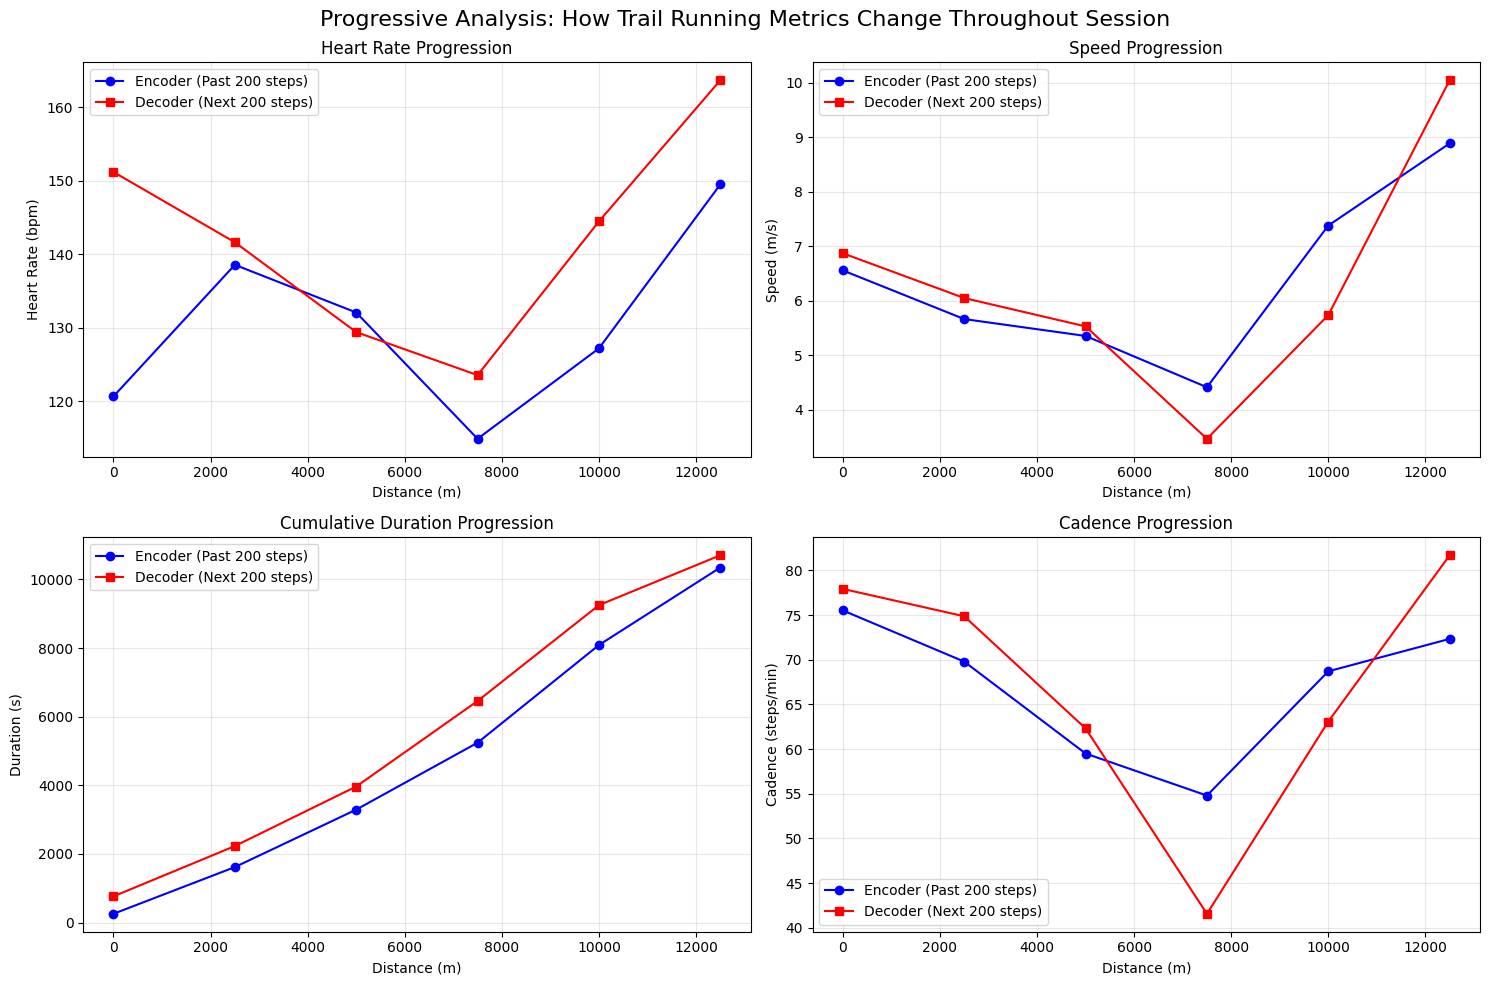


✓ Progressive analysis complete!
✓ Analyzed 6 chunks spanning 0m to 12500m
✓ Shows how encoder (past) and decoder (future) windows change throughout session
✓ This demonstrates the progressive inference capability across the full trail session


In [44]:
# Progressive inference visualization across multiple chunks
import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("PROGRESSIVE INFERENCE ACROSS MULTIPLE CHUNKS")
print("="*60)

# Process multiple chunks from the same session to show progression
session_chunks = [chunk for chunk in sliding_chunks if chunk['session_id'] == sliding_chunks[0]['session_id']]
print(f"Found {len(session_chunks)} chunks from session: {session_chunks[0]['session_id'][:50]}...")

# Select chunks at different progression points (every 10th chunk to show progression)
selected_chunks = session_chunks[::10][:6]  # Take every 10th chunk, max 6 chunks
print(f"Selected {len(selected_chunks)} chunks for progressive analysis")

# Analyze progression through the session
chunk_analysis = []

for i, chunk in enumerate(selected_chunks):
    distance_range = f"{chunk['start_distance']:.0f}m - {chunk['end_distance']:.0f}m"
    chunk_data = chunk['data']
    
    # Get encoder and decoder data
    encoder_data = chunk_data.iloc[:200]
    decoder_data = chunk_data.iloc[200:400]
    
    # Calculate some statistics for this chunk
    analysis = {
        'chunk_idx': i,
        'distance_range': distance_range,
        'start_distance': chunk['start_distance'],
        'end_distance': chunk['end_distance'],
        'encoder_stats': {
            'avg_duration': encoder_data['duration'].mean(),
            'avg_heartrate': encoder_data['heartRate'].mean(),
            'avg_speed': encoder_data['speed'].mean(),
            'avg_cadence': encoder_data['cadence'].mean(),
        },
        'decoder_stats': {
            'avg_duration': decoder_data['duration'].mean(),
            'avg_heartrate': decoder_data['heartRate'].mean(),
            'avg_speed': decoder_data['speed'].mean(),
            'avg_cadence': decoder_data['cadence'].mean(),
        }
    }
    chunk_analysis.append(analysis)
    
    print(f"Chunk {i}: {distance_range}")
    print(f"  Encoder avg: Duration={analysis['encoder_stats']['avg_duration']:.1f}s, HR={analysis['encoder_stats']['avg_heartrate']:.1f}bpm, Speed={analysis['encoder_stats']['avg_speed']:.2f}m/s")
    print(f"  Decoder avg: Duration={analysis['decoder_stats']['avg_duration']:.1f}s, HR={analysis['decoder_stats']['avg_heartrate']:.1f}bpm, Speed={analysis['decoder_stats']['avg_speed']:.2f}m/s")

# Create visualization showing progression through the session
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Progressive Analysis: How Trail Running Metrics Change Throughout Session', fontsize=16)

# Extract data for plotting
distances = [chunk['start_distance'] for chunk in chunk_analysis]
encoder_hr = [chunk['encoder_stats']['avg_heartrate'] for chunk in chunk_analysis]
decoder_hr = [chunk['decoder_stats']['avg_heartrate'] for chunk in chunk_analysis]
encoder_speed = [chunk['encoder_stats']['avg_speed'] for chunk in chunk_analysis]
decoder_speed = [chunk['decoder_stats']['avg_speed'] for chunk in chunk_analysis]
encoder_duration = [chunk['encoder_stats']['avg_duration'] for chunk in chunk_analysis]
decoder_duration = [chunk['decoder_stats']['avg_duration'] for chunk in chunk_analysis]
encoder_cadence = [chunk['encoder_stats']['avg_cadence'] for chunk in chunk_analysis]
decoder_cadence = [chunk['decoder_stats']['avg_cadence'] for chunk in chunk_analysis]

# Plot 1: Heart Rate progression
axes[0, 0].plot(distances, encoder_hr, 'b-o', label='Encoder (Past 200 steps)', markersize=6)
axes[0, 0].plot(distances, decoder_hr, 'r-s', label='Decoder (Next 200 steps)', markersize=6)
axes[0, 0].set_title('Heart Rate Progression')
axes[0, 0].set_xlabel('Distance (m)')
axes[0, 0].set_ylabel('Heart Rate (bpm)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Speed progression
axes[0, 1].plot(distances, encoder_speed, 'b-o', label='Encoder (Past 200 steps)', markersize=6)
axes[0, 1].plot(distances, decoder_speed, 'r-s', label='Decoder (Next 200 steps)', markersize=6)
axes[0, 1].set_title('Speed Progression')
axes[0, 1].set_xlabel('Distance (m)')
axes[0, 1].set_ylabel('Speed (m/s)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Duration progression
axes[1, 0].plot(distances, encoder_duration, 'b-o', label='Encoder (Past 200 steps)', markersize=6)
axes[1, 0].plot(distances, decoder_duration, 'r-s', label='Decoder (Next 200 steps)', markersize=6)
axes[1, 0].set_title('Cumulative Duration Progression')
axes[1, 0].set_xlabel('Distance (m)')
axes[1, 0].set_ylabel('Duration (s)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Cadence progression
axes[1, 1].plot(distances, encoder_cadence, 'b-o', label='Encoder (Past 200 steps)', markersize=6)
axes[1, 1].plot(distances, decoder_cadence, 'r-s', label='Decoder (Next 200 steps)', markersize=6)
axes[1, 1].set_title('Cadence Progression')
axes[1, 1].set_xlabel('Distance (m)')
axes[1, 1].set_ylabel('Cadence (steps/min)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Progressive analysis complete!")
print(f"✓ Analyzed {len(selected_chunks)} chunks spanning {distances[0]:.0f}m to {distances[-1]:.0f}m")
print(f"✓ Shows how encoder (past) and decoder (future) windows change throughout session")
print(f"✓ This demonstrates the progressive inference capability across the full trail session")

## Discusión y Conclusiones

## Resumen de la Implementación

### Organización del Código

El código se organizó en dos módulos principales para mayor claridad y mantenibilidad:

**`data_module.py`**:
- Contiene `TFTDataModule`: DataModule especializado para pytorch-forecasting
- Manejo completo de datos desde carga hasta preparación para TFT
- División temporal inteligente dentro de cada sesión
- Configuración automática de variables conocidas/desconocidas

**`model.py`**:
- Contiene `TrailRunningTFT`: Wrapper de Lightning para TemporalFusionTransformer
- Funciones de entrenamiento y utilidades del modelo
- Configuración optimizada para predicción de tiempo en trail running

### TFTDataModule Implementado

Se creó un `TFTDataModule` personalizado que:
- Carga automáticamente todos los archivos CSV de sesiones de trail running
- Implementa división temporal dentro de cada sesión para entrenamiento/validación/prueba
- Normaliza las características usando `GroupNormalizer` por sesión
- Maneja variables conocidas y desconocidas en el futuro según el problema de predicción
- Es totalmente compatible con `pytorch-forecasting` y `TimeSeriesDataSet`

### Modelo TFT Configurado

- **Arquitectura**: Temporal Fusion Transformer optimizado para series temporales multivariadas
- **Variables conocidas futuras**: altitud, diferencias de elevación, distancia (disponibles al momento de predicción)
- **Variables desconocidas**: frecuencia cardíaca, temperatura, cadencia, velocidad
- **Objetivo**: predicción de tiempo (duration)
- **Configuración**: encoder de 30 pasos, predicción de 5 pasos futuros

### Características Técnicas

- Manejo automático de valores faltantes e inconsistencias temporales
- Normalización por grupos (sesiones) para mejor generalización
- División temporal que respeta la naturaleza secuencial de los datos
- Métricas de evaluación: SMAPE, MAE, RMSE
- Interpretabilidad del modelo con análisis de importancia de características

La implementación está lista para entrenar y evaluar la predicción de tiempo en actividades de trail running usando datos de sensores, con una arquitectura de código limpia y modular.